# Loading and visualizing the dataset

In [1]:
from datasets import load_dataset
data = load_dataset("dair-ai/emotion", "unsplit")

Found cached dataset emotion (C:/Users/jawad/.cache/huggingface/datasets/dair-ai___emotion/unsplit/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd)


  0%|          | 0/1 [00:00<?, ?it/s]

In [2]:
import pandas as pd

# Convert to DataFrame
df = pd.DataFrame(data)

# For splitting the data split columns
df_expanded = pd.json_normalize(df['train'])

# Print samples from the data
print(df_expanded.head())

# Take a portion from the data 
df_expanded = df_expanded.sample(n=30000, random_state=42)

# Take the first n rows from the data
df_expanded = df_expanded.head(30000)


                                                text  label
0  i feel awful about it too because it s my job ...      0
1                              im alone i feel awful      0
2  ive probably mentioned this before but i reall...      1
3           i was feeling a little low few days back      0
4  i beleive that i am much more sensitive to oth...      2


In [4]:
df_expanded.head()

,text,label
36130,i just feel really helpless and heavy hearted,4
138065,ive enjoyed being able to slouch about relax a...,0
146440,i gave up my internship with the dmrg and am f...,4
103337,i dont know i feel so lost,0
315528,i am a kindergarten teacher and i am thoroughl...,4


Basic Statistics of Text Lengths:
count    30000.000000
mean        97.307100
std         56.473788
min          2.000000
25%         54.000000
50%         86.000000
75%        129.000000
max        525.000000
Name: text_length, dtype: float64


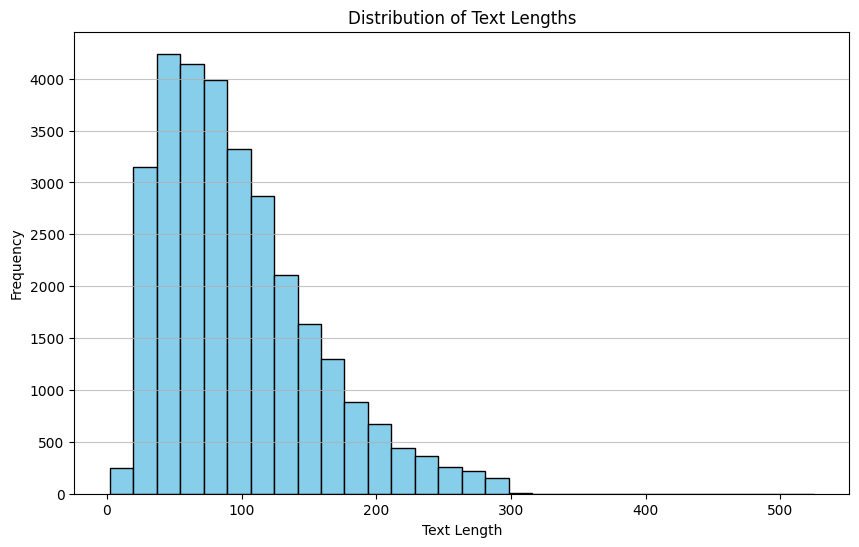

In [3]:
import matplotlib.pyplot as plt


# Calculate text lengths
df_expanded['text_length'] = df_expanded['text'].apply(len)

# Statistics about the lengths of the text
print("Basic Statistics of Text Lengths:")
print(df_expanded['text_length'].describe())

# Visualization
plt.figure(figsize=(10, 6))
plt.hist(df_expanded['text_length'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [4]:
# Assign the labels with its class name
class_names = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}

In [5]:
print(class_names[5])

surprise


In [6]:
# Number of examples for each class
label_counts = df_expanded['label'].value_counts()

print("Label counts in the sampled data:")
print(label_counts)

Label counts in the sampled data:
label
1    10107
0     8908
3     4125
4     3355
2     2400
5     1105
Name: count, dtype: int64


# Split the data into, Train, Validation and Test

In [7]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df_expanded, test_size=0.1, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

# Texts column for X_train and labels column for y_train
X_train = train_data["text"]
y_train = train_data["label"]

X_val = val_data["text"]
y_val = val_data["label"]

X_test = test_data["text"]
y_test = test_data["label"]

# For consistency reset indicies
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)

In [8]:
# Print number of examples for each split
print("Number of training samples:", len(X_train))
print("Number of testing samples:", len(X_test))
print("Number of validation samples:", len(X_val))

Number of training samples: 24300
Number of testing samples: 3000
Number of validation samples: 2700


# Vectorization (text to numbers) using TF-IDF

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorize the text data
vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Training the Logistic model for multiple classes

In [10]:
from sklearn.linear_model import LogisticRegression

# Train the logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_vectorized, y_train)

LogisticRegression(max_iter=1000)

# Model evaluation: Accuracy

In [11]:
from sklearn.metrics import accuracy_score

# Evaluate the model
train_accuracy = accuracy_score(y_train, model.predict(X_train_vectorized))
test_accuracy = accuracy_score(y_test, model.predict(X_test_vectorized))

# Print the accuracies
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Training Accuracy: 0.9370
Test Accuracy: 0.8757


# Comparing model prediction with actual class

In [12]:
index = 0

# Get the label of the text and corresponding class name
actual_train = class_names[y_train[index]]
actual_test = class_names[y_test[index]]

# Get the predicted label with its corresponding class name
predicted_train = class_names[model.predict(X_train_vectorized[index:index+1])[0]]
predicted_test = class_names[model.predict(X_test_vectorized[index:index+1])[0]]

# Print the result
print("Training Data Statement:" , X_train[index])
print(f"Predicted: {predicted_train} , Actual: {actual_train}")
print("Test Data Statement:", X_test[index])
print(f"Predicted: {predicted_test}, Actual: {actual_test}")



Training Data Statement: im sure sometimes feel like i have no idea where im going and when things dont go as i expect i get incredibly stressed
Predicted: anger , Actual: anger
Test Data Statement: i arrived home feeling knackered confused happy and thinking that was the best date i had ever been on
Predicted: joy, Actual: fear


# Fine-tuning BERT

In [13]:
from transformers import BertTokenizer, TFBertForSequenceClassification

# BERT Tokenization as a preprocess step which is the input representation
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# [CLS] [Tok1] ... [Tokn][SEP] from the start to the end of the text
# Classification and Separation

C:\Users\ALI\anaconda3\envs\tf_env\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [14]:
max_len= 100

# BERT encoder for the text data, pad and cut if it is not the same length (max_len)
# It returns input_ids, token_type_ids and attention mask
X_train_encoded = tokenizer.batch_encode_plus(X_train.tolist(),
                                              padding=True, 
                                              truncation=True,
                                              max_length = max_len,
                                              return_tensors='tf')
 
X_val_encoded = tokenizer.batch_encode_plus(X_val.tolist(), 
                                              padding=True, 
                                              truncation=True,
                                              max_length = max_len,
                                              return_tensors='tf')
 
X_test_encoded = tokenizer.batch_encode_plus(X_test.tolist(), 
                                              padding=True, 
                                              truncation=True,
                                              max_length = max_len,
                                              return_tensors='tf')

In [15]:
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
k = 19

# Print the text
print('Training Text -->>',X_train[k])

# Keys of the input words
print('\nInput Ids -->>\n',X_train_encoded['input_ids'][k])

# Decodes the ids to words
print('\nDecoded Ids -->>\n',tokenizer.decode(X_train_encoded['input_ids'][k]))

# Specify which input to process, if 1 process the input, if 0 ignore like the padding
print('\nAttention Mask -->>\n',X_train_encoded['attention_mask'][k])

# Print the labels of the text
print('\nLabels -->>',y_train[k], '-->>', class_names[y_train[k]])

Training Text -->> i feel honoured to be studying alongside everyone i m sure they ll teach me a lot

Input Ids -->>
 tf.Tensor(
[  101  1045  2514 15546  2000  2022  5702  4077  3071  1045  1049  2469
  2027  2222  6570  2033  1037  2843   102     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0], shape=(100,), dtype=int32)

Decoded Ids -->>
 [CLS] i feel honoured to be studying alongside everyone i m sure they ll teach me a lot [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

In [17]:
# Convert to numpy
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
y_test = y_test.to_numpy()

# Initialize model parameters

In [18]:
import tensorflow as tf

# Adam optimizer for adaptive learninig rate
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)

# Loss function 
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# For analyzing the iteration progress use accuracy metric 
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

# Compile using the parameters
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Training the model 

In [19]:
# Start training using the inputs that are created
history = model.fit(
    [X_train_encoded['input_ids'], X_train_encoded['token_type_ids'], X_train_encoded['attention_mask']],
    y_train,
    validation_data=(
      [X_val_encoded['input_ids'], X_val_encoded['token_type_ids'], X_val_encoded['attention_mask']],y_val),
    batch_size=32,
    epochs=7
)

Epoch 1/7
760/760 [==============================] - 230s 289ms/step - loss: 0.5990 - accuracy: 0.7834 - val_loss: 0.1893 - val_accuracy: 0.9219
Epoch 2/7
760/760 [==============================] - 218s 287ms/step - loss: 0.1435 - accuracy: 0.9359 - val_loss: 0.1269 - val_accuracy: 0.9337
Epoch 3/7
760/760 [==============================] - 218s 287ms/step - loss: 0.1073 - accuracy: 0.9444 - val_loss: 0.1138 - val_accuracy: 0.9356
Epoch 4/7
760/760 [==============================] - 218s 287ms/step - loss: 0.0890 - accuracy: 0.9505 - val_loss: 0.1229 - val_accuracy: 0.9341
Epoch 5/7
760/760 [==============================] - 218s 287ms/step - loss: 0.0869 - accuracy: 0.9541 - val_loss: 0.1422 - val_accuracy: 0.9319
Epoch 6/7
760/760 [==============================] - 218s 287ms/step - loss: 0.0814 - accuracy: 0.9563 - val_loss: 0.1452 - val_accuracy: 0.9341
Epoch 7/7
760/760 [==============================] - 218s 287ms/step - loss: 0.0739 - accuracy: 0.9630 - val_loss: 0.1569 - val_ac

In [20]:
#Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(
    [X_test_encoded['input_ids'], X_test_encoded['token_type_ids'], X_test_encoded['attention_mask']],
    y_test
)
print(f'Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}')

94/94 [==============================] - 9s 74ms/step - loss: 0.1234 - accuracy: 0.9387
Test loss: 0.1234, Test accuracy: 0.9387


# Inference

In [21]:
input_text = "i feel like it is not my day at all"

# Tokenize input text
inputs = tokenizer(input_text, return_tensors='tf', padding=True, truncation=True)

# Predict
outputs = model(inputs)

# Extract predicted probabilities
predicted_probabilities = tf.nn.softmax(outputs.logits, axis=-1)

# Convert probabilities to class labels
predicted_class = tf.argmax(predicted_probabilities, axis=1).numpy()[0]

i = 0
# Iterate over each input example
for example_probs in predicted_probabilities:
    # Iterate over the probabilities for each class
    for class_prob in example_probs:
        print(f"{class_names[i]}: {class_prob.numpy()*100:.2f}%")
        i+=1

print("\nPredicted class:", predicted_class, class_names[predicted_class])

sadness: 92.89%
joy: 0.89%
love: 0.18%
anger: 3.34%
fear: 2.20%
surprise: 0.50%

Predicted class: 0 sadness


# Long-Short Term Memory 

# Preprocessing for LSTM Structure

In [22]:
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences


# Tokenize the most repeated words
tokenizer = Tokenizer(num_words=5000)
# Based on most frequent words
tokenizer.fit_on_texts(X_train)


# Maps each word to its integer index
word_index = tokenizer.word_index

# Convert sequence of words to sequence of numbers
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)
X_val_sequences = tokenizer.texts_to_sequences(X_val)

# Determine maximum sequence length
max_seq = max(len(seq) for seq in X_train_sequences + X_val_sequences)


# Pad any sentence less than the max_seq
X_train_sequences = pad_sequences(X_train_sequences, maxlen=max_seq)
X_test_sequences = pad_sequences(X_test_sequences, maxlen=max_seq)
X_val_sequences = pad_sequences(X_val_sequences, maxlen=max_seq)

# Convert the y_train to one hot encoded 3 to [0 0 0 1] 
from keras.utils import to_categorical
y_train_one_hot_encoded = to_categorical(y_train)
y_test_one_hot_encoded = to_categorical(y_test)
y_val_one_hot_encoded = to_categorical(y_val)

# Model Parameters

In [23]:
from keras.optimizers import Adam

# Define the optimizer with the desired learning rate
optimizer = Adam(learning_rate=0.01)
loss='categorical_crossentropy'
metric = ['accuracy']

# Model Architecture

In [24]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dropout, Dense


lstm_model = Sequential([
    # Each word will be represented by a vector of size 200
    Embedding(input_dim=5000, output_dim=200, input_length=max_seq),
    LSTM(128, return_sequences=True),
    Dropout(0.5),
    LSTM(128),
    Dense(64, activation='relu'),
    Dense(6, activation='softmax')
])

lstm_model.compile(loss=loss, optimizer=optimizer, metrics=metric)

# Start training
lstm_model.fit(X_train_sequences, y_train_one_hot_encoded, 
          batch_size=32, epochs=10, 
          validation_data=(X_val_sequences, y_val_one_hot_encoded))

Epoch 1/10
760/760 [==============================] - 13s 14ms/step - loss: 0.9189 - accuracy: 0.6512 - val_loss: 0.3655 - val_accuracy: 0.8926
Epoch 2/10
760/760 [==============================] - 10s 13ms/step - loss: 0.2657 - accuracy: 0.9064 - val_loss: 0.1801 - val_accuracy: 0.9222
Epoch 3/10
760/760 [==============================] - 10s 13ms/step - loss: 0.1987 - accuracy: 0.9234 - val_loss: 0.1883 - val_accuracy: 0.9259
Epoch 4/10
760/760 [==============================] - 10s 13ms/step - loss: 0.1873 - accuracy: 0.9266 - val_loss: 0.1842 - val_accuracy: 0.9207
Epoch 5/10
760/760 [==============================] - 10s 13ms/step - loss: 0.2037 - accuracy: 0.9231 - val_loss: 0.1675 - val_accuracy: 0.9241
Epoch 6/10
760/760 [==============================] - 10s 13ms/step - loss: 0.1765 - accuracy: 0.9286 - val_loss: 0.1999 - val_accuracy: 0.9241
Epoch 7/10
760/760 [==============================] - 10s 13ms/step - loss: 0.1854 - accuracy: 0.9260 - val_loss: 0.1902 - val_accuracy:

# Model Evaluation

In [25]:
#Evaluate the model on the test data
test_loss, test_accuracy = lstm_model.evaluate(X_test_sequences, y_test_one_hot_encoded)
print(f'Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}')

94/94 [==============================] - 0s 5ms/step - loss: 0.1936 - accuracy: 0.9237
Test loss: 0.1936, Test accuracy: 0.9237
